
| EDA dataframe      | Description |due|
| ----------- | ----------- |----------- |
| grape_train  | 캠벨얼리 가격/거래량 + 소비자 물가 지수 + 자동차용경유 + 날씨(4개-평균기온, 평균온량, 일강수량, 일교차) + 수출입(4개) + 재배면적 + 샤인머스켓 거래량 + 실업률_경제활동인구(2개-경제활동인구, 실업률) + 최저시급    |20190101 ~ 20201104|
| shinemuscat_train   |샤인마스캇  가격/거래량 + 소비자 물가 지수 + 자동차용경유 + 날씨(4개-평균기온, 평균온량, 일강수량, 일교차) + 수출입(4개) + 재배면적 + 블루베리 거래량 + 실업률_경제활동인구(2개-경제활동인구, 실업률) + 최저시급        |20190101 ~ 20201104|
| df      | grape_train + shinemuscat_train       | 20190101 ~ 2020928|

## Overview

## 주제:  농산물 품목별 가격 변동 예측 모델 구현

### 과제 선정 배경
코로나 사태가 지속되면서 온라인 시장이 급증하였다. 이에, 가격 변동 예측을 통해 필요한 상품을 필요한 주기에 적정가에 구매하여 구매 비용 및 폐기율 낮춰 생산량 조절


### 과제 주요 내용
- 농산물 가격은 추측이 어려운 경향이 있음. 기격에 영향을 미치는 요인으로 거래량, 기상, 가격,사회적인 이슈, 물가 상승률, 거래량, 유가, 생산량, 해외 수입량, 재배 면적 등 다양하지만, 그중 기상, 유가, 가격, 거래량 데이터를 이용. 해당 데이터들을 수집하여 전처리, 이상치 탐지, 정규화 등의 과정을 거친 뒤, 회귀 기법의 머신러닝 모델 및 딥러닝(LSTM)을 이용하여 모델을 학습하고 예측한다.
- 주기는 1,2,4주로 예측
- 이번 프로젝트에서는 토마토, 포도(캠벨얼리, 샤인마스캇) 총 3개의 작물에 대하여 가격 예측을 진행한다.
- 수요예측 -> 계획 생산 -> 좋은 품질을 연간 균일, 합리적인 가격

**preprocessing : 날씨데이터의 경우 품목별로 재배지역 80%내 재배지역 비율로 전처리**

**EDA : 농산물 품목별 계절 패턴이 뚜렷하고, 품목별로 다른 분포를 보임 -> 시계열 반영 모델 및 폼목별 모델 생성**<br>

**EDA & preprocessing : 주말(공휴일)의 경우 거래가 발생하지 않음 -> 모델 성능 저하 -> 전처리 필요(거래 전, 후의 가격 평균 대체)**

### 과제 목표
- 마켓컬리 '폐기율 0.1%' 도전, 고객의 성향이나 맥락, 상품 특성을 고려해 적절한 시기에 상품을 추천함으로써 고객이 원하는 상품을 빠르고 쉽게 찾아서 주문할 수 있도록 지원하기위해 가격 예측이 필요함
- 입력받은 일자의 1주 뒤의 가격을 예측하는 것을 목표로 한다. 예를 들어, 2021년 12월 31일의 데이터를 입력으로 한다면, 1월 7일, 1월 14일, 1월 28일의 가격을 수치형으로 예측한다. 모델의 성능 평가 지표는 농산물마다 가격 범위 차이가 큰 점을 반영하여 **``RMSE(Root-mean-square deviation)``** 를 사용하며, 해당 값이 0.2가 넘지 않게 하는 것을 목표로 한다.

### 데이터 수집
**train(학습용 데이터셋)**: ``20160101`` ~ ``20200928`` => EDA<br> 
**test(테스트 테이터셋)**: ``20200929 + 1week``~ ``20201104 +4week``


[V] 데이터 수집 기한 정하기 <br>
[ ] RMSE(평가지표) 예측 주기 정하기

### 캠벨얼리 외부데이터
소비자 물가 지수, 자동차용경유, 날씨(4개-평균기온, 평균온량, 일강수량, 일교차), 수출입(4개), 재배면적, 샤인머스켓(빅카인즈) 거래량(워드클라우드)   , 실업률_경제활동인구(2개-경제활동인구, 실업률), 최저시급


### 샤인마스캇 외부데이터
소비자 물가 지수, 자동차용경유, 날씨(4개-평균기온, 평균온량, 일강수량, 일교차), 수출입(4개), 재배면적, 블루베리 거래량(워드클라우드), 실업률_경제활동인구(2개-경제활동인구, 실업률), 최저시급


# 파생변수

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'
# import tensorflow as tf
# import keras
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib as mpl
from IPython.core.display import display, HTML
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import MinMaxScaler, RobustScaler
# from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# from tensorflow.keras import Sequential
# from tensorflow.keras import layers
# from tensorflow.keras.layers import Dense, LSTM, Dropout
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# from statsmodels.tsa.seasonal import seasonal_decompose, STL
import urllib.request
import requests
import json
import datetime
import os
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

/var/folders/08/yfq1rzmx605_pllcn65f77540000gn/T/ipykernel_1982/238796418.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# 0. 데이터셋(dataset)

**train** 20160101 ~ 20200928 <br> 
**test** 20200929 ~ 20201105

EDA와 기본 모델을 만들때 사용 <br>
train + test 합친 프레임(토마토, 포도) = df

In [2]:
# Macbook
raw_path = '/Users/goeun/Documents/YearDream/ProJect/kurly_project/products_price_predict/data/raw/'
processed_path = '/Users/goeun/Documents/YearDream/ProJect/kurly_project/products_price_predict/data/processed/'

In [2]:
# iMACA
# raw_path = '/Users/cge/Documents/yeardream/project/kurly/products_price_predict/data/raw/'
# processed_path = '/Users/cge/Documents/yeardream/project/kurly/products_price_predict/data/processed/'

In [3]:
# test 데이터 합치기
arr = os.listdir('/Users/cge/Documents/yeardream/project/kurly/data/public_data/test_files')
print(arr)
print()

filename_list = arr
filename_list_2020 = []    
for filename in filename_list :
    if '2020' in filename :
        filename_list_2020.append(filename)
        
path = '/Users//cge/Documents/yeardream/project/kurly/data/public_data/test_files/'
df_list = []
for filename in tqdm(filename_list_2020) :
    df = pd.read_csv(path + filename)
    df_list.append(df)
test = pd.concat(df_list, sort=False).reset_index(drop=True)

['test_2020-10-12.csv', 'test_2020-10-06.csv', 'test_2020-10-07.csv', 'test_2020-10-13.csv', 'test_2020-09-30.csv', 'test_2020-10-05.csv', 'test_2020-10-11.csv', 'test_2020-10-10.csv', 'test_2020-10-04.csv', 'test_2020-10-14.csv', 'test_2020-10-28.csv', 'test_2020-10-29.csv', 'test_2020-10-15.csv', 'test_2020-10-01.csv', 'test_2020-10-17.csv', 'test_2020-10-03.csv', 'test_2020-10-02.csv', 'test_2020-10-16.csv', 'test_2020-10-27.csv', 'test_2020-10-26.csv', 'test_2020-10-18.csv', 'test_2020-10-24.csv', 'test_2020-10-30.csv', 'test_2020-10-31.csv', 'test_2020-10-25.csv', 'test_2020-10-19.csv', 'test_2020-10-21.csv', 'test_2020-10-09.csv', 'test_2020-10-08.csv', 'test_2020-10-20.csv', 'test_2020-09-29.csv', 'test_2020-10-22.csv', 'test_2020-10-23.csv', '.ipynb_checkpoints', 'test_2020-11-04.csv', 'test_2020-11-05.csv', 'test_2020-11-02.csv', 'test_2020-11-03.csv', 'test_2020-11-01.csv']



100%|██████████| 38/38 [00:00<00:00, 522.48it/s]


In [3]:
arr2 = os.listdir(processed_path)
arr2

['shinemuscat_weather.csv',
 '.DS_Store',
 '캠벨얼리_전처리후.csv',
 '샤인머스켓_전처리후.csv',
 'shinemuscat.csv',
 'README.md',
 'grape.csv',
 'grape_실업률추가.csv',
 'grape_weather.csv',
 'shinemuscat_실업률추가.csv']

In [23]:
train = pd.read_csv(raw_path + 'train.csv')
test = pd.read_csv(raw_path + 'test.csv')
df = pd.concat([train, test])
mushroom = df[['date','요일','팽이버섯_거래량(kg)', '팽이버섯_가격(원/kg)']]

# train -> 2020년 9월 28일까지만 EDA 진행
mushroom_train = mushroom[:1733]

print(mushroom.shape)
print(mushroom.shape)

(1770, 4)
(1770, 4)


In [25]:
print(f'df')
mushroom.info()

df
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1770 entries, 0 to 36
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1770 non-null   object 
 1   요일             1770 non-null   object 
 2   팽이버섯_거래량(kg)   1770 non-null   float64
 3   팽이버섯_가격(원/kg)  1770 non-null   float64
dtypes: float64(2), object(2)
memory usage: 69.1+ KB


# EDA (df = mushroom)
## 농산물 품목 별 가격 추세
계절 패턴이 뚜렷함 -> 시계열
 품목별로 확연히 다른 분포를 보임 -> 품목별 모델 생성, 시계열 반영 모델 생성

In [15]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date',drop=True,inplace=True)

<AxesSubplot:title={'center':'팽이버섯_가격(원/kg)'}, xlabel='date'>

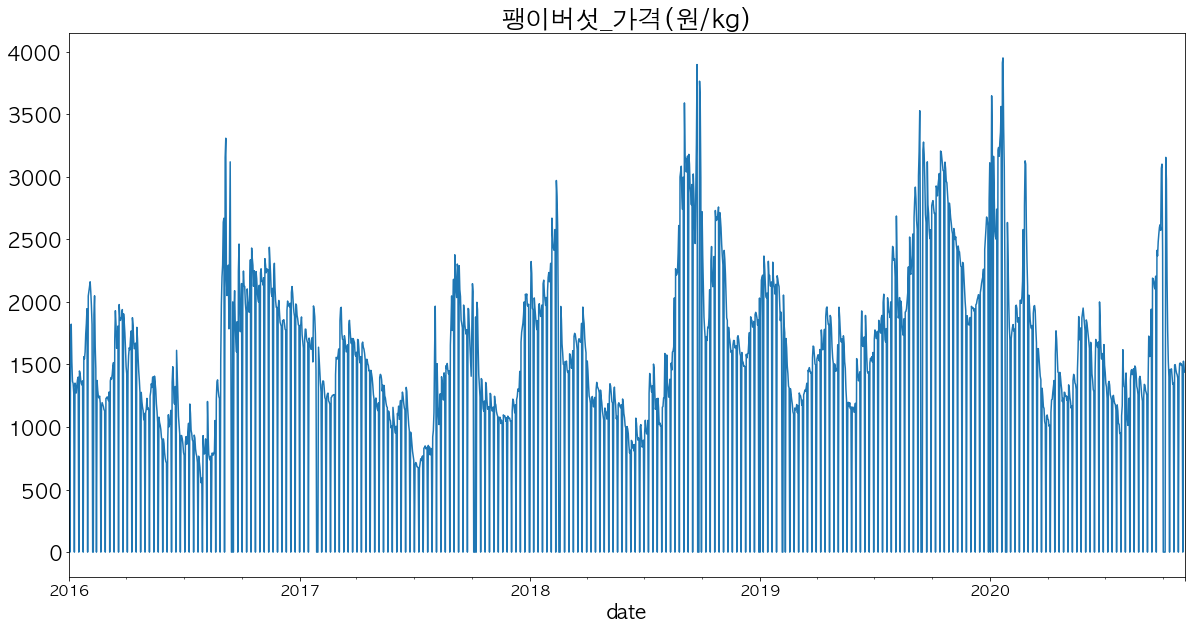

In [17]:
plt.title('팽이버섯_가격(원/kg)', fontsize=25)
plt.xlabel('기간', fontsize = 20)
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 20)
df['팽이버섯_가격(원/kg)'].plot(figsize=(20,10))

(array([265.,  36., 255., 409., 396., 203.,  85.,  57.,  19.,   8.]),
 array([   0. ,  395.1,  790.2, 1185.3, 1580.4, 1975.5, 2370.6, 2765.7,
        3160.8, 3555.9, 3951. ]),
 <BarContainer object of 10 artists>)

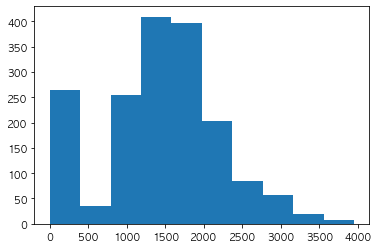

In [18]:
# 팽이버섯 히스토그램 -> 이상치 확인 -> 외부데이터 추가하는 방법

plt.hist(mushroom['팽이버섯_가격(원/kg)' ])
# plt.xscale('log')

In [19]:
mushroom['팽이버섯_가격(원/kg)' ].value_counts()

0.0       265
1346.0      5
1247.0      5
1814.0      4
1690.0      4
         ... 
1406.0      1
2082.0      1
1941.0      1
1387.0      1
3069.0      1
Name: 팽이버섯_가격(원/kg), Length: 1031, dtype: int64

## 농산물 가격 분포
특이값이 많이 포함되어 있음 (이상치가 아니라 우리가 예측해야 하는 값)

<AxesSubplot:>

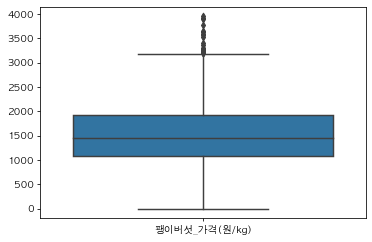

In [20]:
feature = df[['팽이버섯_가격(원/kg)' ]].columns

fig = plt.figure(dpi=70)
plt.xticks(rotation = 0)
sns.boxplot(data = df[feature])

## 특이값 발생 원인


팽이버섯 가격 0이 아닐경우만 시각화 

<AxesSubplot:xlabel='date'>

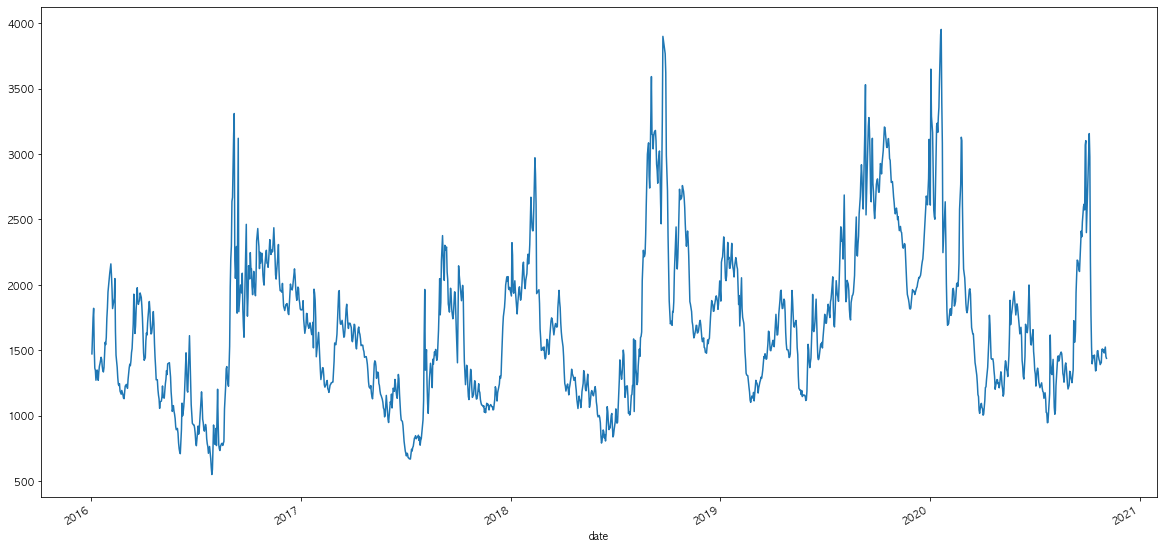

In [21]:
df[df['팽이버섯_가격(원/kg)'] > 1]['팽이버섯_가격(원/kg)'].plot(figsize=(20,10))

## [가격 추세 결론]
> 1. 농산물 품목별 계절 패턴이 뚜렷 <br>
2. 품목별로 다른 분포를 보임 <br>
**=>  시계열 반영 모델 및 폼목별 모델 생성**

## [가격 분포 결론]
> 1. 특이값 분포<br>
2. 외부 요인에 의한 이상치 <br>
**=> 농산물 품목별 영향을 미치는 외부 요인 추가 X **


## Summary Statistics 확인(비시각화)

In [22]:
# 팽이버섯 비시각화
mushroom.describe()

,팽이버섯_거래량(kg),팽이버섯_가격(원/kg)
count,1733.000000,1733.000000
mean,104171.368090,1424.464512
std,47220.947213,806.071718
min,0.000000,0.000000
25%,109745.000000,1071.000000
50%,121304.200000,1454.000000
75%,130877.000000,1923.000000
max,169256.000000,3951.000000


----


##  요일, 년, 월 컬럼 추가

In [26]:
mushroom_train.date = pd.to_datetime(mushroom_train.date)
mushroom_train_date = pd.concat([mushroom_train, pd.get_dummies(mushroom_train['요일'])], axis = 1)
mushroom_train_date['년'] = mushroom_train_date['date'].dt.year 
mushroom_train_date['월'] = mushroom_train_date['date'].dt.month 

In [28]:
display(mushroom_train_date.head(2))
display(mushroom_train_date.tail(2))
print(mushroom_train_date.shape)

,date,요일,팽이버섯_거래량(kg),팽이버섯_가격(원/kg),금요일,목요일,수요일,월요일,일요일,토요일,화요일,년,월
0,2016-01-01,금요일,0.0,0.0,1,0,0,0,0,0,0,2016,1
1,2016-01-02,토요일,14634.0,1474.0,0,0,0,0,0,1,0,2016,1


,date,요일,팽이버섯_거래량(kg),팽이버섯_가격(원/kg),금요일,목요일,수요일,월요일,일요일,토요일,화요일,년,월
1731,2020-09-27,일요일,2500.0,2573.0,0,0,0,0,1,0,0,2020,9
1732,2020-09-28,월요일,166041.5,3069.0,0,0,0,1,0,0,0,2020,9


(1733, 13)


## 1. 팽이버섯 EDA (grape_train)
### 1-1. 팽이버섯 거래량이 가격에 영향을 끼치는가?
> **[결론]생산량과 가격은 상관관계 거의 없음**

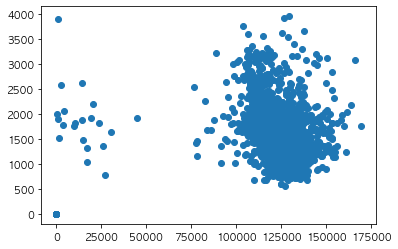

In [30]:
x = mushroom_train['팽이버섯_거래량(kg)']
y = mushroom_train['팽이버섯_가격(원/kg)']

plt.plot(x, y, 'o')
plt.show()

### 1-3. 팽이버섯의 가격은 날씨데이터(계절)에 영향을 끼치는가?
> 가격과 날씨데이터간의 상관관계 유의하지 않음

In [33]:
mushroom_weather = mushroom_train_date[['년','월','팽이버섯_가격(원/kg)']]
mushroom_weather.corr()

,년,월,팽이버섯_가격(원/kg)
년,1.000000,-0.109649,0.146186
월,-0.109649,1.000000,0.111732
팽이버섯_가격(원/kg),0.146186,0.111732,1.000000


In [34]:
mushroom_season = mushroom_weather.copy()

# 계절 = 0: 겨울(12~2월) // 1 : 봄(3~5월) // 2: 여름(6~8월) // 3: 가을(9~11월)
mushroom_season['계절'] = (mushroom_season['월'] // 3 % 4) 
mushroom_season[200:]

,년,월,팽이버섯_가격(원/kg),계절
200,2016,7,912.0,2
201,2016,7,826.0,2
202,2016,7,787.0,2
203,2016,7,766.0,2
204,2016,7,715.0,2
...,...,...,...,...
1728,2020,9,2545.0,3
1729,2020,9,2598.0,3
1730,2020,9,2617.0,3
1731,2020,9,2573.0,3


In [35]:
season_list = []
for season in mushroom_season['계절']:
    if season == 0:
        season_list.append('겨울')
    elif season == 1:
        season_list.append('봄')
    elif season == 2:
        season_list.append('여름')
    else:
        season_list.append('가을')

mushroom_season['계절_한글'] = season_list

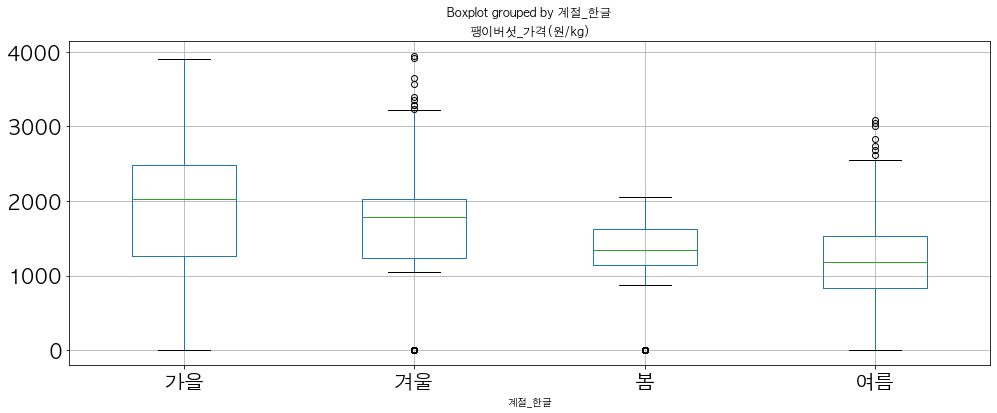

In [36]:
mushroom_season.boxplot(column='팽이버섯_가격(원/kg)', by = '계절_한글', figsize=(16,6) , fontsize=20)
mushroom_season.drop(columns=['계절_한글'], inplace=True)

In [37]:
mushroom_season.iloc[:,2:].corr()

,팽이버섯_가격(원/kg),계절
팽이버섯_가격(원/kg),1.000000,0.085179
계절,0.085179,1.000000


<AxesSubplot:title={'center':'팽이버섯_가격(원/kg)'}, xlabel='월'>

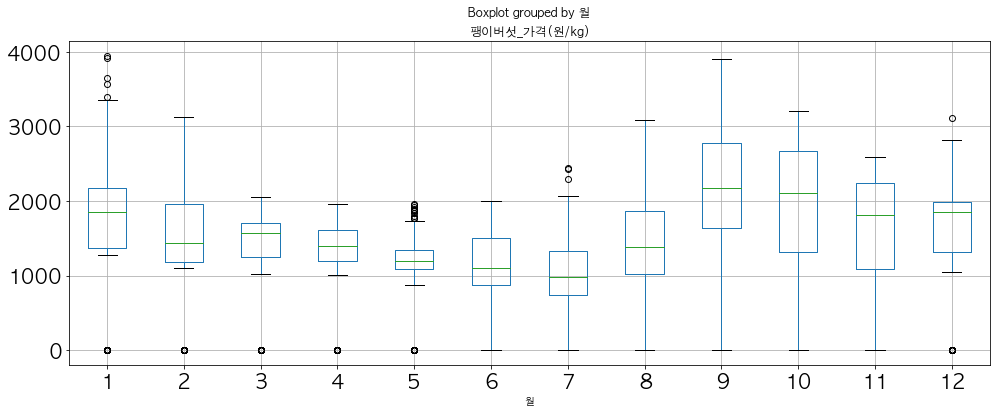

In [38]:
mushroom_season.boxplot(column='팽이버섯_가격(원/kg)', by = '월', figsize=(16,6), fontsize=20)

<AxesSubplot:title={'center':'팽이버섯_가격(원/kg)'}, xlabel='년'>

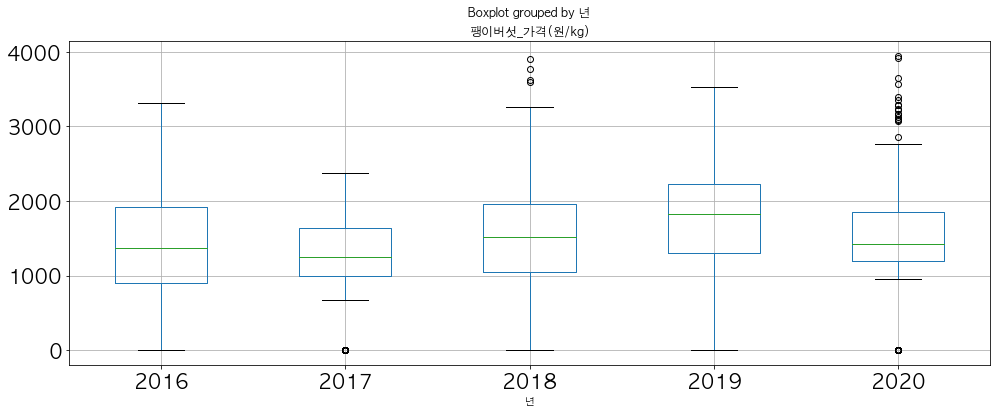

In [39]:
mushroom_season.boxplot(column='팽이버섯_가격(원/kg)', by = '년', figsize=(16,6), fontsize=20)

In [33]:
grape_season.iloc[:,2:].corr()

,캠벨얼리_가격(원/kg),계절
캠벨얼리_가격(원/kg),1.000000,-0.056574
계절,-0.056574,1.000000


----

# Data Preproceesing (df = train, test & grape+shinemuscat)


- 파생변수 생성 (17일까지, git 업로드)
    - 1주전 , 2주전 가격 + 전년도 평균, 계절 평균 가격
    - 1주전 , 2주전 거래량 + 전년도 평균, 계절 평균 거래량
    - 날짜의 데이터 - [계절 파생변수 생성](https://stackoverflow.com/questions/16139306/determine-season-given-timestamp-in-python-using-datetime) (현재 날짜 기준: 입춘, 입동 …)
       

In [42]:
preprocessing = mushroom.copy()
print(preprocessing.shape)
preprocessing.head(2)

(1770, 4)


,date,요일,팽이버섯_거래량(kg),팽이버섯_가격(원/kg)
0,2016-01-01,금요일,0.0,0.0
1,2016-01-02,토요일,14634.0,1474.0


In [43]:
preprocessing.describe()

,팽이버섯_거래량(kg),팽이버섯_가격(원/kg)
count,1770.000000,1770.000000
mean,104047.693503,1422.375706
std,47362.202344,806.819552
min,0.000000,0.000000
25%,109714.250000,1071.750000
50%,121313.900000,1454.000000
75%,130855.250000,1918.750000
max,169256.000000,3951.000000


In [44]:
preprocessing.date = pd.to_datetime(preprocessing.date)
preprocessing['월'] = preprocessing['date'].dt.month 
preprocessing['년'] = preprocessing['date'].dt.year 

# 계절 = 0: 겨울(12~2월) // 1 : 봄(3~5월) // 2: 여름(6~8월) // 3: 가을(9~11월)
preprocessing['계절'] = (preprocessing['월'] // 3 % 4) 
# preprocessing.drop(columns=['월','년'], inplace=True)
print(preprocessing.shape)
preprocessing.head(2)

(1770, 7)


,date,요일,팽이버섯_거래량(kg),팽이버섯_가격(원/kg),월,년,계절
0,2016-01-01,금요일,0.0,0.0,1,2016,0
1,2016-01-02,토요일,14634.0,1474.0,1,2016,0


In [48]:
preprocessing[preprocessing['팽이버섯_가격(원/kg)'] > 3500]

,date,요일,팽이버섯_거래량(kg),팽이버섯_가격(원/kg),월,년,계절
976,2018-09-03,월요일,106437.5,3591.0,9,2018,3
996,2018-09-23,일요일,700.0,3898.0,9,2018,3
1000,2018-09-27,목요일,103954.0,3765.0,9,2018,3
1001,2018-09-28,금요일,125699.0,3620.0,9,2018,3
1349,2019-09-11,수요일,128707.6,3529.0,9,2019,3
1463,2020-01-03,금요일,137634.0,3648.0,1,2020,0
1478,2020-01-18,토요일,114820.0,3563.0,1,2020,0
1480,2020-01-20,월요일,126294.6,3912.0,1,2020,0
1481,2020-01-21,화요일,129463.0,3951.0,1,2020,0


### 1, 2주전 거래량 & 가격 파생변수 생성

In [49]:
# 1주 전 가격들의 평균내기(월~일, 0으로 된 날 개수 세는 코드와 그에 따른 평균 내는 코드로)
# index 기준 10~16, 17~23, ...
# index 기준 0~9는 농넷에서 찾아야 할 듯 합니다. so 2015년 12월 28부터 2015년 12월 31일까지 4일간의 데이터 찾아보자.

A = [];B = []
for x in range(10):
    A.append(0)
    B.append(0)

for y in range(246):
    s = 0;t = 0
    for z in range(7):
        s += preprocessing['팽이버섯_거래량(kg)'].iloc[(y * 7) + z + 3]
        t += preprocessing['팽이버섯_가격(원/kg)'].iloc[(y * 7) + z + 3]
    v_1 = (preprocessing['팽이버섯_거래량(kg)'].iloc[(y * 7) + 3:(y * 7) + 10] == 0).sum()
    v_2 = (preprocessing['팽이버섯_가격(원/kg)'].iloc[(y * 7) + 3:(y * 7) + 10] == 0).sum()
    for w in range(7):
        A.append(s / (7 - v_1))
        B.append(t / (7 - v_2))
for z in range(7):
    s += preprocessing['팽이버섯_거래량(kg)'].iloc[1725 + z]
    t += preprocessing['팽이버섯_가격(원/kg)'].iloc[1725 + z]
v_1 = (preprocessing['팽이버섯_거래량(kg)'].iloc[1725:1732] == 0).sum()
v_2 = (preprocessing['팽이버섯_가격(원/kg)'].iloc[1725:1732] == 0).sum()
A.append(s / (7 - v_1))
B.append(t / (7 - v_2))
Adf = pd.DataFrame(A, columns = ['팽이버섯_거래량의_1주전_평균'])
Bdf = pd.DataFrame(B, columns = ['팽이버섯_가격의_1주전_평균'])
preprocessing_1 = pd.concat([preprocessing, Adf, Bdf], axis=1)
# preprocessing_1

In [50]:
# 2주 전 가격들의 평균내기(월~일, 0으로 된 날 개수 세는 코드와 그에 따른 평균 내는 코드로)
# index 기준 10~23, 24~37, ...
# index 기준 0~16는 농넷에서 찾아야 할 듯 합니다. so 2015년 12월 21부터 2015년 12월 31일까지 11일간의 데이터 찾아보자.

C = [];D = []
for x in range(17):
    C.append(0)
    D.append(0)

for y in range(245):
    s = 0;t = 0
    for z in range(14):
        s += preprocessing['팽이버섯_거래량(kg)'].iloc[(y * 7) + z + 3]
        t += preprocessing['팽이버섯_가격(원/kg)'].iloc[(y * 7) + z + 3]
    v_1 = (preprocessing['팽이버섯_거래량(kg)'].iloc[(y * 7) + 3:(y * 7) + 17] == 0).sum()
    v_2 = (preprocessing['팽이버섯_가격(원/kg)'].iloc[(y * 7) + 3:(y * 7) + 17] == 0).sum()
    for w in range(7):
        C.append(s / (14 - v_1))
        D.append(t / (14 - v_2))
for z in range(14):
    s += preprocessing['팽이버섯_거래량(kg)'].iloc[1718 + z]
    t += preprocessing['팽이버섯_가격(원/kg)'].iloc[1718 + z]
v_1 = (preprocessing['팽이버섯_거래량(kg)'].iloc[1718:1732] == 0).sum()
v_2 = (preprocessing['팽이버섯_가격(원/kg)'].iloc[1718:1732] == 0).sum()
C.append(s / (14 - v_1))
D.append(t / (14 - v_2))
Cdf = pd.DataFrame(C, columns = ['팽이버섯_거래량의_2주전_평균'])
Ddf = pd.DataFrame(D, columns = ['팽이버섯_가격의_2주전_평균'])
preprocessing_2 = pd.concat([preprocessing_1, Cdf, Ddf], axis=1)
# preprocessing_2

In [51]:
# 계절 = 0: 겨울(12~2월) // 1 : 봄(3~5월) // 2: 여름(6~8월) // 3: 가을(9~11월)
preprocessing_2.계절.value_counts()

1    460
2    460
3    429
0    421
Name: 계절, dtype: int64

In [52]:
preprocessing_2.isna().sum()

date                0
요일                  0
팽이버섯_거래량(kg)        0
팽이버섯_가격(원/kg)       0
월                   0
년                   0
계절                  0
팽이버섯_거래량의_1주전_평균    0
팽이버섯_가격의_1주전_평균     0
팽이버섯_거래량의_2주전_평균    0
팽이버섯_가격의_2주전_평균     0
dtype: int64

In [53]:
# 계절별 평균가격
print(preprocessing_2.loc[preprocessing_2.계절 == 0, '팽이버섯_가격(원/kg)'].mean())
print(preprocessing_2.loc[preprocessing_2.계절 == 1, '팽이버섯_가격(원/kg)'].mean())
print(preprocessing_2.loc[preprocessing_2.계절 == 2, '팽이버섯_가격(원/kg)'].mean())
print(preprocessing_2.loc[preprocessing_2.계절 == 3, '팽이버섯_가격(원/kg)'].mean())

# 계절별 평균거래량
print()
print(preprocessing_2.loc[preprocessing_2.계절 == 0, '팽이버섯_거래량(kg)'].mean())
print(preprocessing_2.loc[preprocessing_2.계절 == 1, '팽이버섯_거래량(kg)'].mean())
print(preprocessing_2.loc[preprocessing_2.계절 == 2, '팽이버섯_거래량(kg)'].mean())
print(preprocessing_2.loc[preprocessing_2.계절 == 3, '팽이버섯_거래량(kg)'].mean())

1557.7790973871734
1238.0326086956522
1149.4782608695652
1779.7785547785547

102945.13420427547
110413.1539130435
103169.8615217391
99245.52191142189


In [54]:
preprocessing_2.columns

Index(['date', '요일', '팽이버섯_거래량(kg)', '팽이버섯_가격(원/kg)', '월', '년', '계절',
       '팽이버섯_거래량의_1주전_평균', '팽이버섯_가격의_1주전_평균', '팽이버섯_거래량의_2주전_평균',
       '팽이버섯_가격의_2주전_평균'],
      dtype='object')

## 캠벨얼리, 샤인머스켓 파일저장

In [57]:
mushroom_preprocessed = preprocessing_2[['date', '요일', '팽이버섯_거래량(kg)', '팽이버섯_가격(원/kg)', 
                           '팽이버섯_거래량의_1주전_평균', '팽이버섯_가격의_1주전_평균', '팽이버섯_거래량의_2주전_평균',
                           '팽이버섯_가격의_2주전_평균','계절']]
mushroom_preprocessed.shape

(1770, 9)

In [58]:
mushroom_preprocessed.to_csv(processed_path+'팽이버섯_전처리후.csv', index = False)

## 상관분석

### 전처리 후 상관분석

In [61]:
preprocessing_mushroom = preprocessing_2[['date', '요일', '팽이버섯_거래량(kg)', '팽이버섯_가격(원/kg)',
                           '팽이버섯_거래량의_1주전_평균', '팽이버섯_가격의_1주전_평균', '팽이버섯_거래량의_2주전_평균',
                           '팽이버섯_가격의_2주전_평균','계절']]

### 켐벨얼리 상관계수, p-value 검정

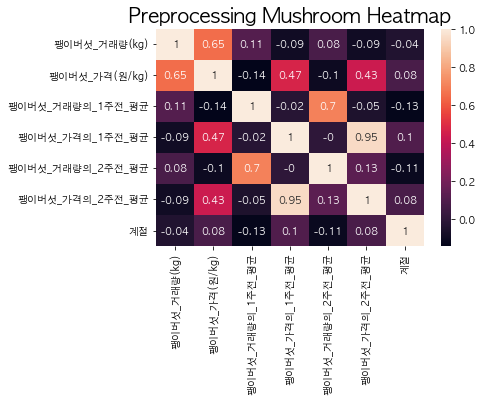

In [62]:
preprocessing_mushroom_corr = preprocessing_mushroom.copy()
preprocessing_mushroom_corr = preprocessing_mushroom_corr.corr().round(2)
ax = sns.heatmap(preprocessing_mushroom_corr, annot=True)
plt.title('Preprocessing Mushroom Heatmap', fontsize=20)
plt.show()

In [64]:
import scipy.stats as stats

Y =  preprocessing_mushroom['팽이버섯_가격(원/kg)'].values

for item in ['팽이버섯_거래량(kg)', '팽이버섯_거래량의_1주전_평균', '팽이버섯_가격의_1주전_평균', 
             '팽이버섯_거래량의_2주전_평균', '팽이버섯_가격의_2주전_평균','계절']:
    print(item)
    X = preprocessing_mushroom[item].values
    print('Covariance:{:.2f}'.format(np.cov(X,Y)[0,1]))
    print('Correlation:{:.2f}'.format(stats.pearsonr(X,Y)[0]))
    print('P-value:{:.4f}'.format(stats.pearsonr(X,Y)[1]))
    print('\n')

팽이버섯_거래량(kg)
Covariance:25011098.45
Correlation:0.65
P-value:0.0000


팽이버섯_거래량의_1주전_평균
Covariance:-1857418.07
Correlation:-0.14
P-value:0.0000


팽이버섯_가격의_1주전_평균
Covariance:223973.64
Correlation:0.47
P-value:0.0000


팽이버섯_거래량의_2주전_평균
Covariance:-1559564.16
Correlation:-0.10
P-value:0.0000


팽이버섯_가격의_2주전_평균
Covariance:206348.95
Correlation:0.43
P-value:0.0000


계절
Covariance:70.16
Correlation:0.08
P-value:0.0009


